In [29]:
import sys
sys.path.insert(0, '../../../savanna/')

from savanna.utils.dataset import *
from savanna.inference.conv_mf import ConvMF
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.fc1 = nn.Linear(250, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, b):
        d = b.view(-1, 250)
        d = F.relu(self.fc1(d))
        d = F.relu(self.fc2(d))
        d = self.fc3(d)
        return d

In [ ]:
#Data Loading
#trainset, testset = get_dataset("./CIFAR", "CIFAR10", is_numpy=False)
#train_images = trainset.data
#train_labels = trainset.targets

#test_images = testset.data
#test_labels = testset.targets

In [2]:
#Data Loading
(train_images, train_labels), (test_images, test_labels) = get_dataset("./CIFAR", "CIFAR10", is_numpy=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#Image sizes
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [69]:
#Displays an image


plt.imshow(train_images[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [5]:
#Converting all the images to grayscale
from skimage.color import rgb2gray

train_images_gray = np.zeros((50000, 32, 32))
test_images_gray = np.zeros((10000, 32, 32))

for i in range(len(train_images)):
    train_images_gray[i] = rgb2gray(train_images[i])
    
for i in range(len(test_images)):
    test_images_gray[i] = rgb2gray(test_images[i])


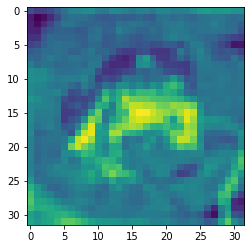

In [6]:
plt.imshow(train_images_gray[0])

In [7]:
#Creating ConvMF Object
MorF = ConvMF(tree_type = "S-RerF", type = 'split_forest', num_trees = 25, num_split_trees = 50)

In [8]:
#Not using the Network class here; not completely built yet
temp = MorF.fit(train_images_gray, train_labels)

In [25]:
#Print out examples of output
i = 100
print(temp[i])
print(train_labels[i])

[[0.1  0.02 0.04 0.   0.02 0.02 0.   0.   0.78 0.02]
 [0.14 0.   0.04 0.02 0.04 0.   0.02 0.   0.72 0.02]
 [0.04 0.   0.   0.02 0.02 0.04 0.   0.   0.84 0.04]
 [0.06 0.   0.   0.02 0.04 0.   0.   0.   0.88 0.  ]
 [0.06 0.   0.04 0.   0.   0.   0.   0.   0.9  0.  ]
 [0.1  0.   0.   0.02 0.02 0.02 0.04 0.   0.78 0.02]
 [0.08 0.02 0.02 0.04 0.06 0.   0.   0.   0.76 0.02]
 [0.12 0.   0.   0.   0.06 0.02 0.02 0.   0.78 0.  ]
 [0.04 0.   0.08 0.   0.02 0.02 0.   0.04 0.8  0.  ]
 [0.08 0.   0.06 0.02 0.06 0.   0.   0.   0.76 0.02]
 [0.04 0.02 0.04 0.   0.02 0.   0.   0.   0.84 0.04]
 [0.08 0.04 0.02 0.02 0.   0.02 0.   0.02 0.78 0.02]
 [0.12 0.   0.06 0.   0.02 0.   0.   0.   0.8  0.  ]
 [0.06 0.04 0.06 0.   0.   0.   0.02 0.02 0.8  0.  ]
 [0.14 0.   0.04 0.02 0.04 0.02 0.   0.02 0.72 0.  ]
 [0.1  0.   0.02 0.04 0.02 0.   0.   0.02 0.78 0.02]
 [0.08 0.   0.02 0.   0.04 0.02 0.   0.   0.8  0.04]
 [0.14 0.   0.06 0.02 0.   0.04 0.   0.02 0.68 0.04]
 [0.08 0.02 0.08 0.   0.   0.02 0.04 0.   0.76

In [26]:
#Calculates MORF Accuracy
results = MorF.final_predict(test_images_gray)
nsamples = len(results)
count = 0
for i in range(len(results)):
    if results[i] == test_labels[i]:
        count += 1
score = count/nsamples
print("MorF Testing Accuracy")
print(score)


results = MorF.final_predict(train_images_gray)
nsamples = len(results)
count = 0
for i in range(len(results)):
    if results[i] == train_labels[i]:
        count += 1
score = count/nsamples
print("MorF Training Accuracy")
print(score)

MorF Testing Accuracy
0.4435
MorF Training Accuracy
1.0


In [40]:
#MorF Output of Testing Set
testing_MorF_output = MorF.predict(test_images_gray)

In [27]:
#Converts Training_MorF_Output to a Tensor
training_MorF_output = torch.from_numpy(training_MorF_output)
training_MorF_output = training_MorF_output.double()

In [41]:
#Converts Testing_MorF_output to a Tensor
testing_MorF_output = torch.from_numpy(testing_MorF_output)
testing_MorF_output = testing_MorF_output.double()

In [43]:
#Convert labels to tensors
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)

In [49]:
net = CustomNet()
net.double()

CustomNet(
  (fc1): Linear(in_features=250, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

In [52]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



running_loss = 0.0
epoch = 2
for i in range(1000):
    # get the inputs; data is a list of [inputs, labels]
    #inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(training_MorF_output)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    
    #add scoring
    # print statistics
    running_loss += loss.item()
    if i % 250 == 249:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
                #add score
        running_loss = 0.0
        
        
        count = 0
        outputs = net(testing_MorF_output)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.numpy()
        nsamples = len(predicted)
        for i in range(len(predicted)):
            if predicted[i] == test_labels[i]:
                count += 1
        score = count/nsamples
        print("Running Accuracy")
        print(score)

print('Finished Training')





[3,   250] loss: 0.002
Running Accuracy
0.4433
[3,   500] loss: 0.002
Running Accuracy
0.444
[3,   750] loss: 0.001
Running Accuracy
0.4441
[3,  1000] loss: 0.001
Running Accuracy
0.4441
Finished Training


In [67]:
#Plot of Neural Network Training
from matplotlib import pyplot as plt

%matplotlib qt
#Filled in the data manually, but pulled from various experiments (results copy and pasted below)
x = np.arange(250, 3250, 250)
y = np.array([0.1741, 0.3013, 0.3961, 0.4398, 0.4418, 0.4434, 0.4438, 0.4444, 0.443, 0.444, 0.4441, 0.4441])

plt.figure(1)
plt.plot(x, y, label = 'ConvMF + NN Accuracy')
plt.hlines(0.4435, 0, 3000, linestyles = 'dotted', label = 'ConvMF Accuracy')
plt.xlabel('NN Training Epochs')
plt.ylabel('Accuracy on Test Set')
plt.legend()

In [ ]:
#Regular RF
from sklearn.ensemble import RandomForestClassifier

(_, train_labels), (_, test_labels) = get_dataset("./CIFAR", "CIFAR10", is_numpy=True)



clf = RandomForestClassifier(n_estimators=1250)
clf.fit(training_images_gray, train_labels)

results = []

for row in test_set_no_label:
    a = np.array(row)[np.newaxis]
    results.append(clf.predict(a))

results = np.array(results)

count = 0
for i in range(len(results)):
    if results[i] == test_set_labels[i]:
        count += 1

accuracy = count/len(results)
print(accuracy)

In [ ]:


[1,   250] loss: 0.282
Running Accuracy
0.1741
[1,   500] loss: 0.259
Running Accuracy
0.3013
[1,   750] loss: 0.191
Running Accuracy
0.3961
[1,  1000] loss: 0.067
Running Accuracy
0.4398


[2,   250] loss: 0.016
Running Accuracy
0.4418
[2,   500] loss: 0.006
Running Accuracy
0.4434
[2,   750] loss: 0.004
Running Accuracy
0.4438
[2,  1000] loss: 0.003
Running Accuracy
0.4444
Finished Training

[3,   250] loss: 0.002
Running Accuracy
0.4433
[3,   500] loss: 0.002
Running Accuracy
0.444
[3,   750] loss: 0.001
Running Accuracy
0.4441
[3,  1000] loss: 0.001
Running Accuracy
0.4441
Finished Training